In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.getipython import get_ipython
from IPython.display import Javascript
import pandas as pd
import seaborn as sns
import math
import os


In [24]:
from load_results import load_results
from load_results import get_list_of_test_runs
from load_results import get_list_of_projects
from load_results import load_results_for_all_runs
from load_results import get_percentage_of_queries_with_correct_results
from load_results import plot_chance_of_getting_correct_result_in_n_lines
from load_results import get_percentage_of_examples_with_correct_results
from load_results import get_average_position_of_a_correct_results
from load_results import iterate_queries

projects = get_list_of_projects()
list_of_test_runs = get_list_of_test_runs()
list_of_test_runs

['gt -C1', 'initial test']

In [25]:
examples = load_results(list_of_test_runs[0])

## Quality of example cases

(array([20.,  0.,  0.,  0.,  0.,  2.,  9., 13.,  2.,  0.,  0.,  0.,  4.,
        26., 41., 21.,  6.,  3.,  4.,  8., 20., 64., 59., 24.,  4.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ,
        41.8, 45.6, 49.4, 53.2, 57. , 60.8, 64.6, 68.4, 72.2, 76. , 79.8,
        83.6, 87.4, 91.2, 95. ]),
 <BarContainer object of 25 artists>)

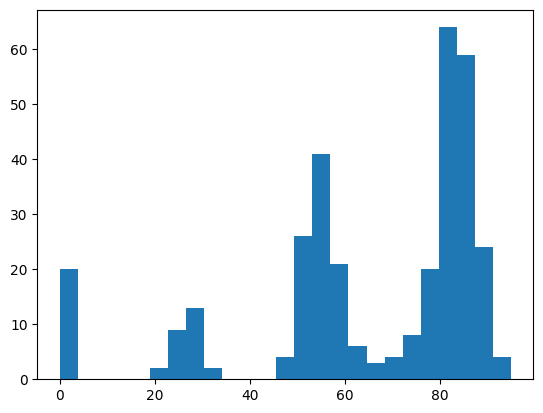

In [26]:
plt.hist([x['qualityScore'] for x in examples], 25)

### Total number of examples

In [27]:
len(examples)

330

### Number of examples after quality cutoff

In [28]:
MINIMUM_EXAMPLE_QUALITY = 75
examples = [example for example in examples if example['qualityScore'] >= MINIMUM_EXAMPLE_QUALITY]
len(examples)

174

(array([ 9., 12., 15., 24., 30., 52., 13.,  9.,  6.,  4.]),
 array([75., 77., 79., 81., 83., 85., 87., 89., 91., 93., 95.]),
 <BarContainer object of 10 artists>)

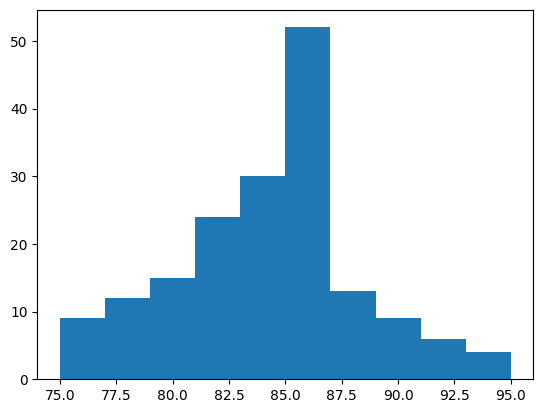

In [29]:
plt.hist([x['qualityScore'] for x in examples], 10)

## List of test runs

In [30]:
all_results = load_results_for_all_runs(MINIMUM_EXAMPLE_QUALITY)
df = pd.DataFrame(all_results, columns=["Test run name", "Data", "Engine"])
df.drop(columns=["Data"])

,Test run name,Engine
0,random,random
1,gt -C1,seagoat
2,initial test,seagoat


## Test quality vs result position

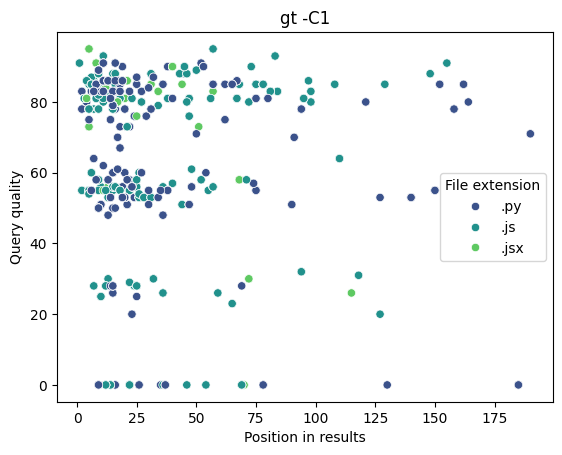

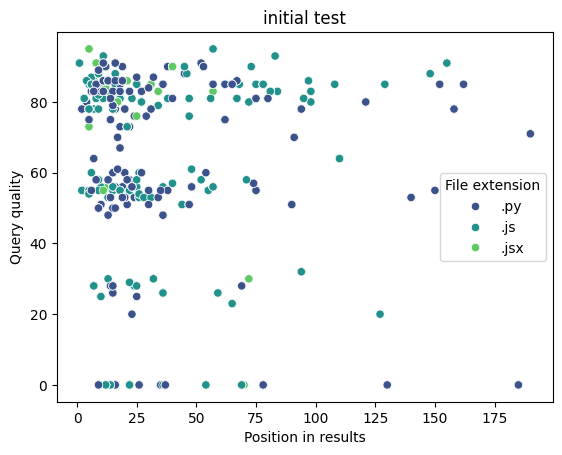

In [31]:
for test_run in list_of_test_runs:
    examples_df = pd.DataFrame(iterate_queries(load_results(test_run)))
    examples_df['Position in results'] = examples_df.apply(lambda row: row['positionOfCorrectResult']['seagoat'], axis=1)
    examples_df['Repository'] = examples_df.apply(lambda row: row['repo']['name'], axis=1)
    examples_df['Query quality'] = examples_df.apply(lambda row: row['qualityScore'], axis=1)
    examples_df['File extension'] = examples_df.apply(lambda row: os.path.splitext(row['targetCode']['path'])[1], axis=1)
    examples_df = examples_df.drop(columns=["queries", "uuid", "text", "repo", "targetCode", "positionOfCorrectResult", "qualityScore"])
    sns.scatterplot(
        x='Position in results', 
        y='Query quality', 
        hue='File extension',
        data=examples_df,
        palette="viridis"
    ).set_title(test_run)
    plt.show()

## Chance of finding a correct result by query quality

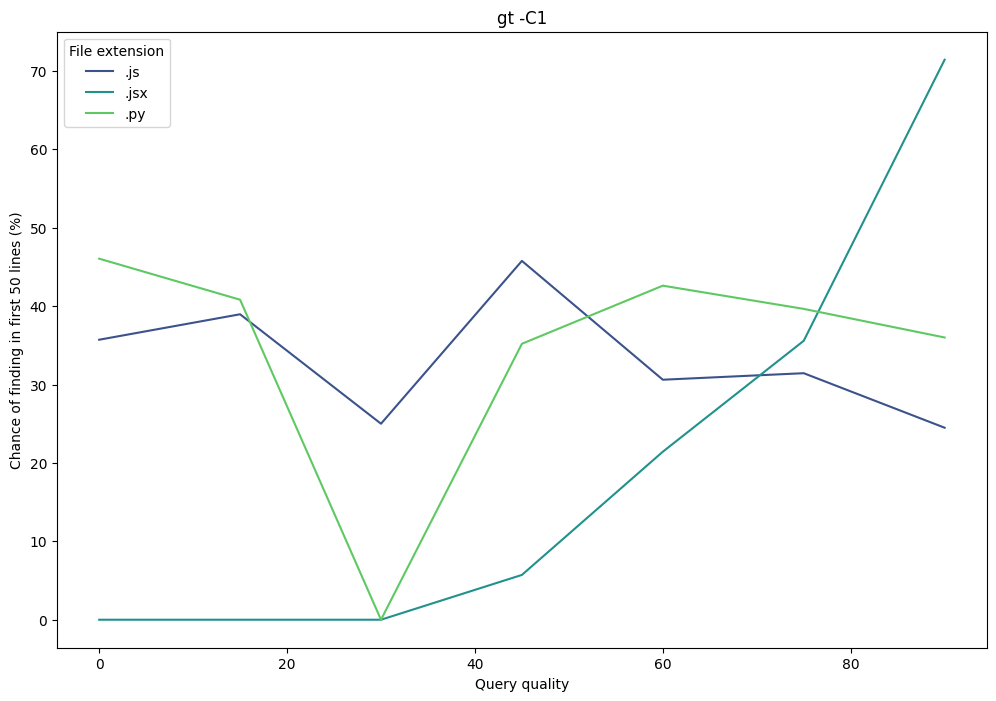

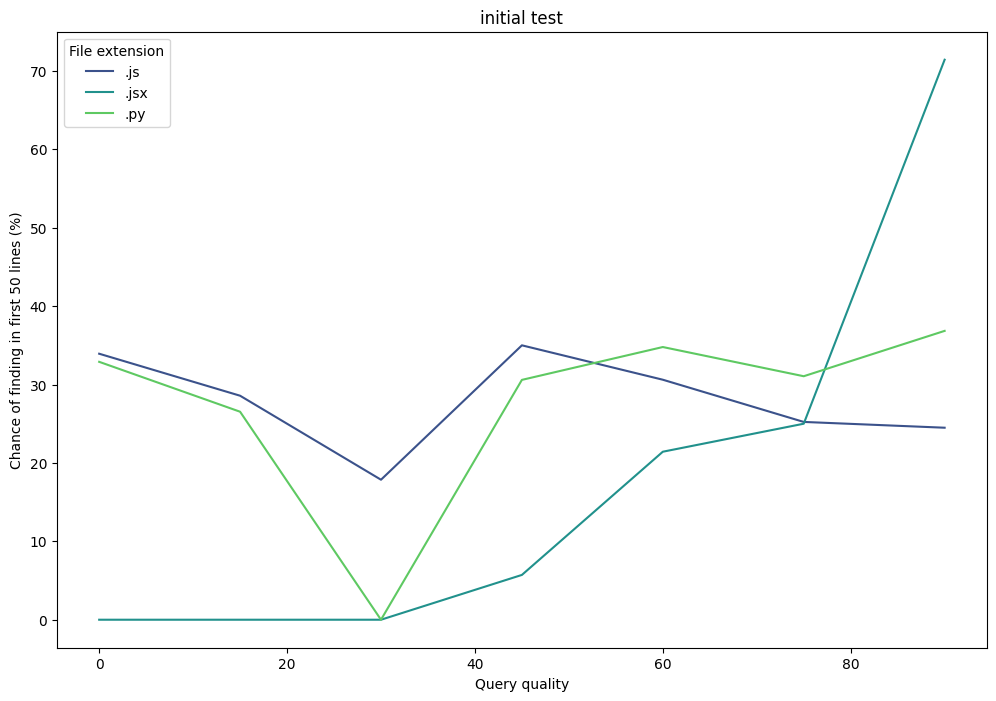

In [32]:
def bin_query_quality(val, bin_size=15):
    return math.floor(val / bin_size) * bin_size

def compute_chance(df):
    within_50 = df[df['Position in results'] <= 50].shape[0]
    total = df.shape[0]
    return (within_50 / total) * 100


for test_run in list_of_test_runs:
    examples_df = pd.DataFrame(iterate_queries(load_results(test_run)))
    examples_df['Position in results'] = examples_df.apply(lambda row: row['positionOfCorrectResult']['seagoat'], axis=1)
    examples_df['Repository'] = examples_df.apply(lambda row: row['repo']['name'], axis=1)
    examples_df['Query quality'] = examples_df.apply(lambda row: row['qualityScore'], axis=1)
    examples_df['File extension'] = examples_df.apply(lambda row: os.path.splitext(row['targetCode']['path'])[1], axis=1)
    
    examples_df['Query quality bin'] = examples_df['Query quality'].apply(bin_query_quality)
    
    summary_df = examples_df.groupby(['File extension', 'Query quality bin']).apply(compute_chance).reset_index()
    summary_df.columns = ['File extension', 'Query quality bin', 'Chance (%)']
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        x='Query quality bin',
        y='Chance (%)',
        hue='File extension',
        data=summary_df,
        palette="viridis"
    ).set_title(test_run)
    plt.xlabel('Query quality')
    plt.ylabel('Chance of finding in first 50 lines (%)')
    plt.show()

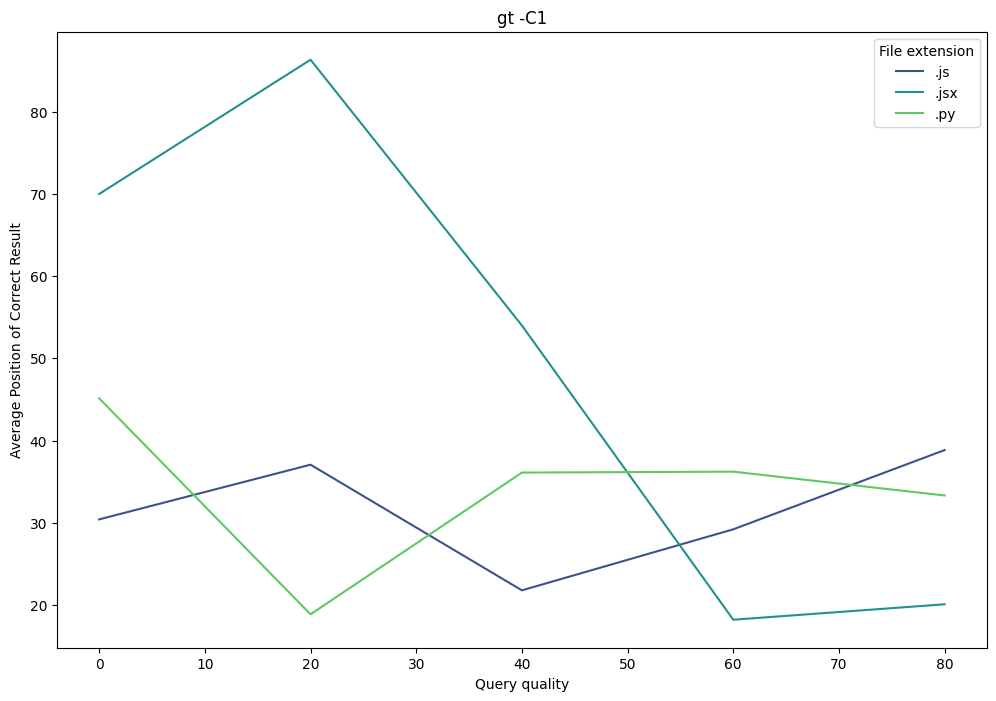

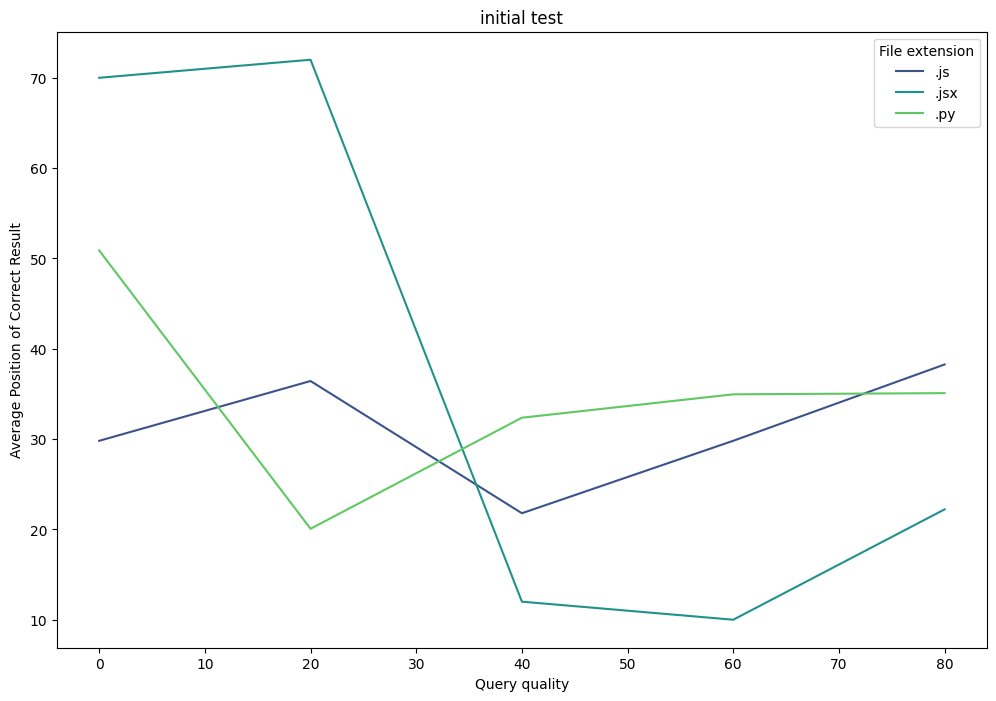

In [33]:
def bin_query_quality(val, bin_size=20):
    return math.floor(val / bin_size) * bin_size

def compute_average_position(df):
    valid_positions = df[df['Position in results'].notna()]['Position in results']
    return valid_positions.mean()

for test_run in list_of_test_runs:
    examples_df = pd.DataFrame(iterate_queries(load_results(test_run)))
    examples_df['Position in results'] = examples_df.apply(lambda row: row['positionOfCorrectResult']['seagoat'], axis=1)
    examples_df['Repository'] = examples_df.apply(lambda row: row['repo']['name'], axis=1)
    examples_df['Query quality'] = examples_df.apply(lambda row: row['qualityScore'], axis=1)
    examples_df['File extension'] = examples_df.apply(lambda row: os.path.splitext(row['targetCode']['path'])[1], axis=1)
    
    examples_df['Query quality bin'] = examples_df['Query quality'].apply(bin_query_quality)
    
    summary_df = examples_df.groupby(['File extension', 'Query quality bin']).apply(compute_average_position).reset_index()
    summary_df.columns = ['File extension', 'Query quality bin', 'Average Position']  # Changed the column name
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        x='Query quality bin',
        y='Average Position',
        hue='File extension',
        data=summary_df,
        palette="viridis"
    ).set_title(test_run)
    plt.xlabel('Query quality')
    plt.ylabel('Average Position of Correct Result')
    plt.show()

## List of projects

## Comparison of accuracy between test runs

In [34]:
def generate_filter(project):
    return lambda result: result['repo']['name'] == project

project_filters = [
    ['All projects', lambda _: True],
] + [[project, generate_filter(project)] for project in projects]

results_filtered_by_project_filter = [
    [
        project_title,
        [[run_name, [result for result in result_data if filter_function(result)], engine] for run_name, result_data, engine in all_results],
    ]
    for project_title, filter_function in project_filters
]

for project_title, filtered_results in results_filtered_by_project_filter:
    df = pd.DataFrame(filtered_results, columns=["Test run name", "Data", "Engine"])
    df['Examples'] = df.apply(lambda row: len(row['Data']), axis=1)
    df['Queries'] = df.apply(lambda row: sum([len(x['queries']) for x in row['Data']]), axis=1)
    df['Query success %'] = df.apply(get_percentage_of_queries_with_correct_results, axis=1).apply(lambda x: "{:.2%}".format(x))
    df['Workflow success %'] = df.apply(get_percentage_of_examples_with_correct_results, axis=1).apply(lambda x: "{:.2%}".format(x))
    df['Average position of result'] = df.apply(get_average_position_of_a_correct_results, axis=1)
    
    display(df.drop(columns=["Data"]).style.set_caption(project_title))

,Test run name,Engine,Examples,Queries,Query success %,Workflow success %,Average position of result
0,random,random,174,1225,0.65%,4.60%,30.875000
1,gt -C1,seagoat,174,1225,46.86%,85.06%,34.837979
2,initial test,seagoat,175,1232,38.31%,76.57%,35.076271


,Test run name,Engine,Examples,Queries,Query success %,Workflow success %,Average position of result
0,random,random,101,707,0.42%,2.97%,41.333333
1,gt -C1,seagoat,101,707,43.14%,83.17%,33.580328
2,initial test,seagoat,101,707,35.08%,72.28%,33.306452


,Test run name,Engine,Examples,Queries,Query success %,Workflow success %,Average position of result
0,random,random,73,518,0.97%,6.85%,24.600000
1,gt -C1,seagoat,73,518,51.93%,87.67%,36.263941
2,initial test,seagoat,74,525,42.67%,82.43%,37.035714


## Chance of correct result by line N

### By test run

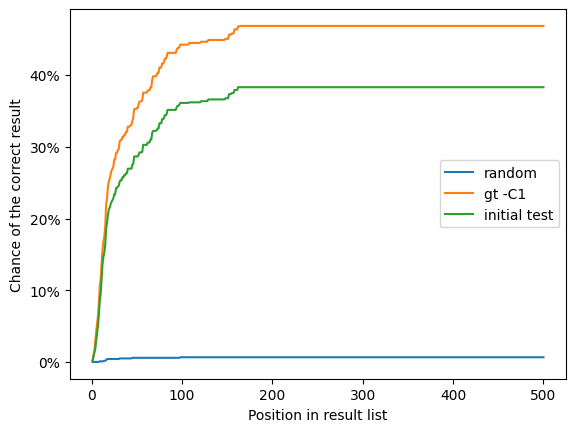

In [35]:
plot_chance_of_getting_correct_result_in_n_lines(all_results, lambda test_run, query, engine, example: test_run)

### By project

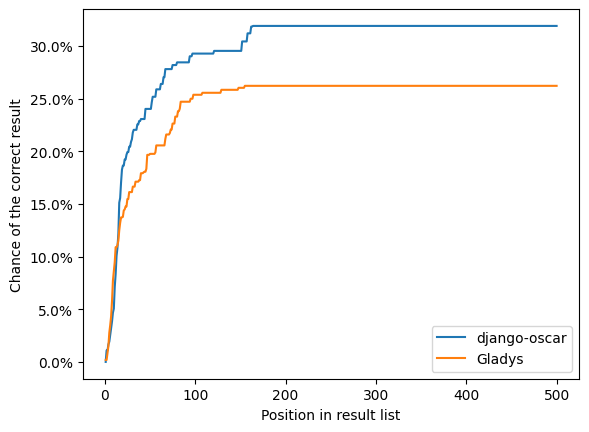

In [36]:
plot_chance_of_getting_correct_result_in_n_lines(all_results, lambda test_run, query, engine, example: example['repo']['name'])

### By file extension

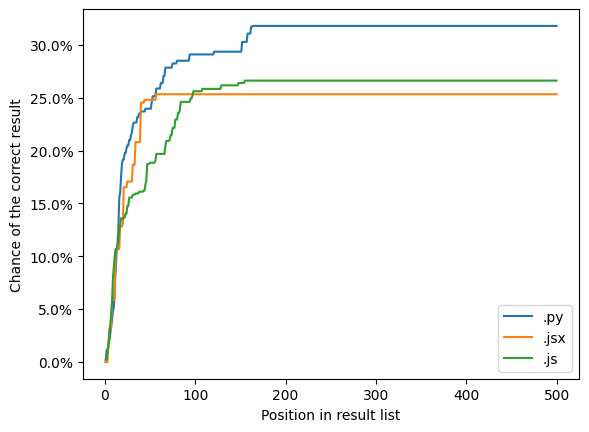

In [37]:
import os
plot_chance_of_getting_correct_result_in_n_lines(all_results, lambda test_run, query, engine, example: os.path.splitext(example['targetCode']['path'])[1])